In [0]:
import matplotlib.pyplot as plt

In [0]:
import torch
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal



class VBGP:
  def __init__(self, num_support_points, dim ):
    self.M = num_support_points
    self.D = dim
    self.device = "cuda"

    self.theta0 = torch.rand(1, requires_grad=True )
    self.theta1 = torch.rand(1, requires_grad=True )
    self.theta2 = torch.rand(1, requires_grad=True )
    self.theta3 = torch.rand(1, requires_grad=True )

    self.support_points = torch.tensor( np.random.rand(self.M, self.D)*10, requires_grad=True  )


  def k(self, xi, xj):
    #return torch.exp(self.theta0) * torch.exp(-0.5 * torch.exp(self.theta1) * torch.sum((xi - xj) * (xi - xj))) + self.theta2 + self.theta3 * torch.sum(xi * xj)
    #return torch.exp(self.theta0) * torch.exp(-0.5 * torch.exp(self.theta1) * torch.sum((xi - xj) * (xi - xj))) 
    return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj))) 

  def cov(self, xi, xj ):
    I = len(xi)
    J = len(xj)
    K = torch.zeros(I,J)
    K.to(self.device)
    for i in range(I):
      for j in range(J):
        K[i][j] = self.k(xi[i], xj[j])
    return K

  def learn(self, xt, yt ):
    self.xt = torch.Tensor(xt)
    self.yt = torch.Tensor(yt)
    N = len(xt)

    # to gpu
    self.xt.to(self.device)
    self.yt.to(self.device)
    self.theta0.to(self.device)
    self.theta1.to(self.device)
    self.support_points.to(self.device)

    #optimizer = torch.optim.SGD( [self.support_points], lr=0.5)
    optimizer = torch.optim.Adam( [self.theta0, self.theta1, self.support_points], lr=1.0)

    self.sig2 = 1.0

    for i in range(1000):
      # カーネル行列を定義
      self.Kmm = self.cov( self.support_points, self.support_points )
      self.Kmm_inv = torch.inverse( self.Kmm+torch.eye(self.M, self.M) )
      self.Knm = self.cov( self.xt, self.support_points )
      self.Kmn = torch.t( self.Knm )
      self.Knn = self.cov( self.xt, self.xt )
      self.Knn_ = torch.mm( torch.mm(self.Knm, self.Kmm_inv), self.Kmn )

      # loss関数を定義
      gauss = MultivariateNormal(torch.zeros(N), self.sig2*torch.eye(N)+self.Knn_)
      loss = -gauss.log_prob(self.yt) + torch.trace( self.Knn - self.Knn_ ) / (2*self.sig2)

      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()

      # 論文中のΣ，A,B
      self.S = torch.inverse( self.Kmm + 1/self.sig2 * torch.mm(self.Kmn, self.Knm) )
      A = torch.mm( torch.mm(self.Kmm, self.S ), self.Kmm )
      self.B = torch.mm(torch.mm(self.Kmm_inv, A), self.Kmm_inv )

      if i%100==0:
        print(loss)  
        print(self.support_points[0])
        self.plot()
        




  def plot(self):
      x = np.linspace( 0,20,100 )
      mus, sigmas = self.predict( x.reshape(-1,1) )
      plt.plot( x, mus )
      
      y_max = mus + np.sqrt(sigmas.flatten())
      y_min = mus - np.sqrt(sigmas.flatten())

      plt.fill_between(x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )

      for p in self.support_points.detach().numpy():
        plt.plot( p, [0.0], "kx" )
      plt.plot(self.xt, self.yt)
      plt.show()


  def predict( self, x ):
    x = torch.tensor(x)
    mus = []
    sigmas = []
    K = len(x)

    for k in range(K):
        Kxm = self.cov( x[k], self.support_points )
        Kmx = torch.t( Kxm )

        #print(torch.mm(torch.mm( Kxm, self.S ), self.Kmn))

        #mu = 1/self.sig2 * torch.sum( torch.mm( torch.mm( Kxm, self.S ), self.Kmn)*self.yt )
        #sig = torch.mm( torch.mm(Kxm, self.S), Kmx )

        sig = self.cov(x[k], x[k]) 
        sig += -torch.mm(torch.mm( Kxm, self.Kmm_inv), Kmx)
        sig += torch.mm( torch.mm( Kxm, self.B ), Kmx )

        mu = torch.mm(Kxm, self.Kmm_inv )
        #print("*****")
        #print(mu)
        #print("*****")
        #print(1/self.sig2 * torch.mm( torch.mm( torch.mm( self.Kmm, self.S ), self.Kmn), self.yt.reshape(-1,1) ) )
        mu = torch.mm(mu, 1/self.sig2 * torch.mm( torch.mm( torch.mm( self.Kmm, self.S ), self.Kmn), self.yt.reshape(-1,1) ) )
        #print(mu)

        
        mus.append(mu.detach().numpy().flatten()[0])
        sigmas.append(sig.detach().numpy().flatten()[0])
    
    return np.array(mus), np.array(sigmas)



In [0]:
gp = VBGP( 20, 1 )

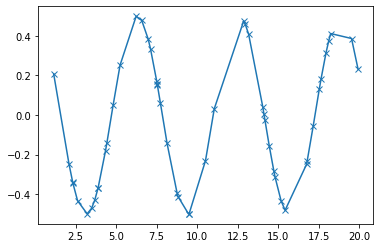

In [205]:
xt = np.sort(np.random.rand(50)*20)
yt = np.cos(xt)/2

plt.plot( xt, yt, "x-" )

tensor(67.4256, grad_fn=<AddBackward0>)
tensor([4.3876], dtype=torch.float64, grad_fn=<SelectBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in sqrt


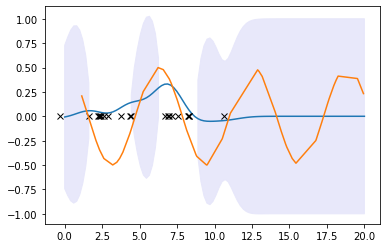

tensor(64.1440, grad_fn=<AddBackward0>)
tensor([4.6491], dtype=torch.float64, grad_fn=<SelectBackward>)


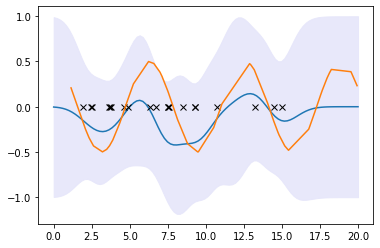

tensor(64.1437, grad_fn=<AddBackward0>)
tensor([4.6393], dtype=torch.float64, grad_fn=<SelectBackward>)


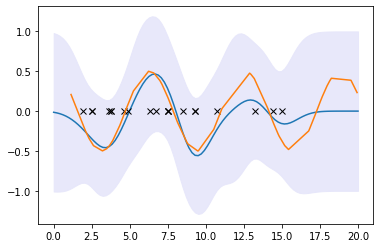

tensor(64.1437, grad_fn=<AddBackward0>)
tensor([4.6393], dtype=torch.float64, grad_fn=<SelectBackward>)


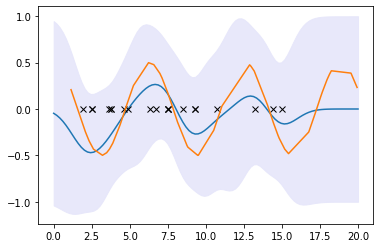

tensor(64.1449, grad_fn=<AddBackward0>)
tensor([4.8664], dtype=torch.float64, grad_fn=<SelectBackward>)


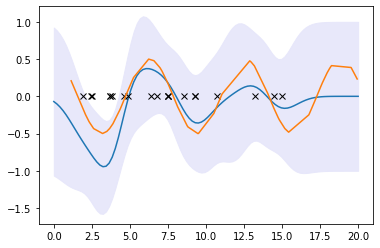

tensor(64.1468, grad_fn=<AddBackward0>)
tensor([4.8236], dtype=torch.float64, grad_fn=<SelectBackward>)


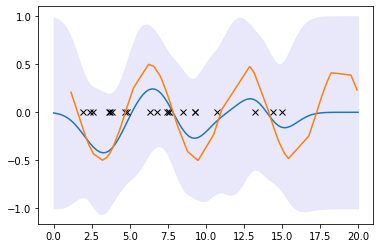

tensor(64.1481, grad_fn=<AddBackward0>)
tensor([4.9940], dtype=torch.float64, grad_fn=<SelectBackward>)


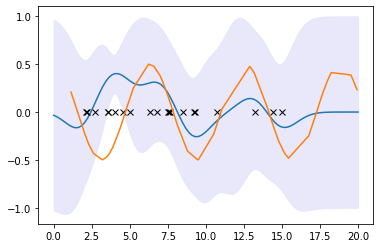

tensor(64.1450, grad_fn=<AddBackward0>)
tensor([4.9577], dtype=torch.float64, grad_fn=<SelectBackward>)


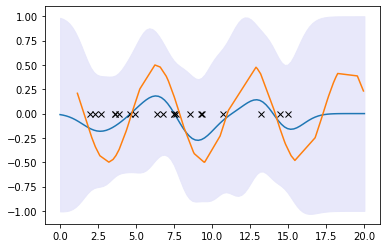

tensor(64.1453, grad_fn=<AddBackward0>)
tensor([4.9697], dtype=torch.float64, grad_fn=<SelectBackward>)


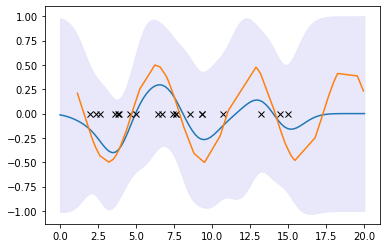

tensor(64.1467, grad_fn=<AddBackward0>)
tensor([4.9092], dtype=torch.float64, grad_fn=<SelectBackward>)


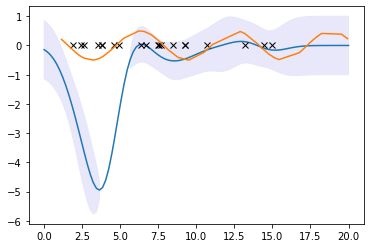

In [206]:
gp.learn( xt.reshape((-1,1)), yt )

In [0]:
x = np.linspace( 0,10,100 )
mus, sigmas = gp.predict( x.reshape(-1,1) )